# Install, import and initialize
First, we shall import basic libraries for handling dataset and training the model

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.datasets import fashion_mnist

# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

# Import W&B and login
Login the Weights & bias service with the given token

In [2]:
import wandb
from wandb.keras import WandbCallback

project_name = 'project-fashion-mnist'
# %env WANDB_API_KEY='1af04e33e3d441eb82eb612e2c001eddec29bccb'

wandb.login(relogin=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Avni Eshchar/.netrc


True

# Download and prepare the dataset
First we download the dataset, then we enrich it by adding an augmented version to it. Lastly, we normalize to the 0-1 range

In [3]:
import albumentations as A
from class_names import class_names

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=(-15, 15))
])

X_train_augmented = np.copy(x_train)
y_train_augmented = np.copy(y_train)

for i, image in enumerate(X_train_augmented ):
    X_train_augmented[i] = transform(image=image)['image']
    
x_train, y_train = np.concatenate([x_train, X_train_augmented]), np.concatenate([y_train, y_train_augmented])

# Subsetting train data and normalizing to [0., 1.]
x_train, x_test = x_train / 255., x_test / 255.
input_shape = (28, 28, 1)
num_classes = len(class_names)

print('Shape of x_train: ', x_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of x_test: ', x_test.shape)
print('Shape of y_test: ', y_test.shape)

Shape of x_train:  (120000, 28, 28)
Shape of y_train:  (120000,)
Shape of x_test:  (10000, 28, 28)
Shape of y_test:  (10000,)


### Regular fashion dataset

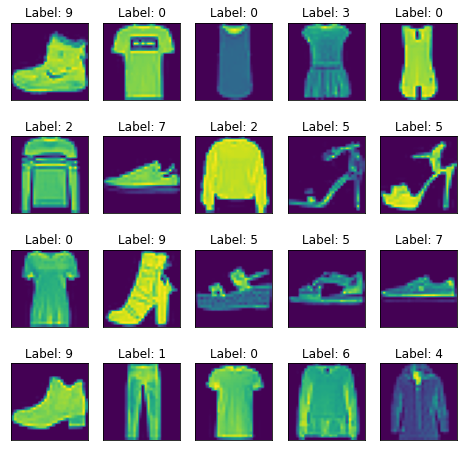

In [4]:
fig = plt.figure(figsize=(8, 8))
fig.clear()
for i in range(20):
    ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    ax.imshow(x_train[i])
    ax.set_title(f"Label: {y_train_augmented[i]}")

### Augmented dataset

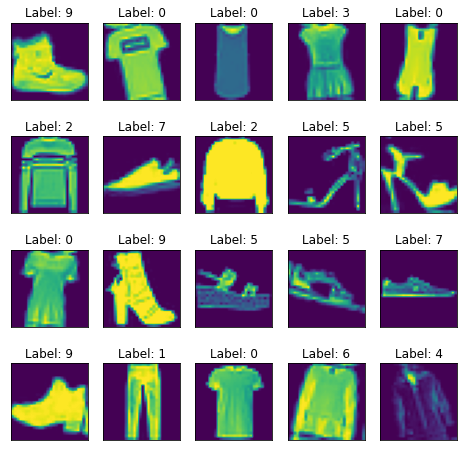

In [5]:
fig = plt.figure(figsize=(8, 8))
for i in range(20):
    ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    ax.imshow(X_train_augmented[i])
    ax.set_title(f"Label: {y_train_augmented[i]}")

# Define a model

Here, we define a standard CNN (with convolution and max-pooling) in Keras.

In [6]:
def Model():
    inputs = keras.layers.Input(shape=input_shape)

    x = keras.layers.Conv2D(filters=28, kernel_size=(3, 3), activation='relu')(inputs)
    x = keras.layers.Conv2D(filters=28, kernel_size=(3, 3), activation='relu')(x)
    x = keras.layers.MaxPooling2D(pool_size=2)(x)

    x = keras.layers.Conv2D(filters=28, kernel_size=(3, 3), activation='relu')(x)
    x = keras.layers.Conv2D(filters=28, kernel_size=(3, 3), activation='relu')(x)
    x = keras.layers.GlobalAveragePooling2D()(x)

    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dense(28, activation='relu')(x)

    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

    return keras.models.Model(inputs=inputs, outputs=outputs, )

# Train the model

In [7]:
# Initialize wandb with your project name
run = wandb.init(project=project_name,
                 config={
                     "learning_rate": 0.001,
                     "epochs": 5,
                     "batch_size": 32,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "CNN",
                     "dataset": "fashion_mnist"
                 })
config = wandb.config  # We'll use this to configure our experiment

# Initialize model like you usually do.
keras.backend.clear_session()
model = Model()
model.summary()

# Compile model like you usually do.
optimizer = tf.keras.optimizers.Adam(config.learning_rate) 
model.compile(optimizer, config.loss_function, metrics=['acc'])

wandb: Currently logged in as: eshcharc. Use `wandb login --relogin` to force relogin


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 28)        280       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 28)        7084      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 28)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 28)        7084      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 28)          7084      
                                                             

In [8]:
# We focus on a subset of images, since this is for human review
val_images, val_labels = x_test[:32], y_test[:32]

_ = model.fit(x_train, y_train,
              epochs=config.epochs, 
              batch_size=config.batch_size,
              validation_data=(x_test, y_test),
              callbacks=[WandbCallback(data_type='image', 
                                       validation_data=(val_images, val_labels), 
                                       labels=class_names)])

run.finish()

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
wandb: WARNING The data_type argument of wandb.keras.WandbCallback is deprecated and will be removed in a future release. Please use input_type instead.
wandb: WARNING Setting input_type = data_type.


Epoch 1/5
2/2 [==============================] - 0s 2ms/step0s - loss: 0.7531 - acc: 0.71


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230117_071133-3ek55a5g\files\model-best\assets


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230117_071133-3ek55a5g\files\model-best\assets
wandb: Adding directory to artifact (d:\dev\elbit\ML-course\project-2\wandb\run-20230117_071133-3ek55a5g\files\model-best)... Done. 0.0s


3750/3750 [==============================] - 76s 20ms/step - loss: 0.7530 - acc: 0.7151 - val_loss: 0.5404 - val_acc: 0.8031
Epoch 2/5
2/2 [==============================] - 0s 3ms/step0s - loss: 0.4781 - acc: 0.82


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230117_071133-3ek55a5g\files\model-best\assets


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230117_071133-3ek55a5g\files\model-best\assets
wandb: Adding directory to artifact (d:\dev\elbit\ML-course\project-2\wandb\run-20230117_071133-3ek55a5g\files\model-best)... Done. 0.0s


3750/3750 [==============================] - 77s 20ms/step - loss: 0.4780 - acc: 0.8252 - val_loss: 0.4229 - val_acc: 0.8502
Epoch 3/5
2/2 [==============================] - 0s 3ms/step0s - loss: 0.3919 - acc: 0.85


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230117_071133-3ek55a5g\files\model-best\assets


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230117_071133-3ek55a5g\files\model-best\assets
wandb: Adding directory to artifact (d:\dev\elbit\ML-course\project-2\wandb\run-20230117_071133-3ek55a5g\files\model-best)... Done. 0.0s


3750/3750 [==============================] - 74s 20ms/step - loss: 0.3919 - acc: 0.8570 - val_loss: 0.3513 - val_acc: 0.8750
Epoch 4/5
2/2 [==============================] - 0s 2ms/step0s - loss: 0.3486 - acc: 0.87


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230117_071133-3ek55a5g\files\model-best\assets


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230117_071133-3ek55a5g\files\model-best\assets
wandb: Adding directory to artifact (d:\dev\elbit\ML-course\project-2\wandb\run-20230117_071133-3ek55a5g\files\model-best)... Done. 0.0s


3750/3750 [==============================] - 76s 20ms/step - loss: 0.3486 - acc: 0.8725 - val_loss: 0.3314 - val_acc: 0.8822
Epoch 5/5
2/2 [==============================] - 0s 3ms/step0s - loss: 0.3192 - acc: 0.88


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230117_071133-3ek55a5g\files\model-best\assets


INFO:tensorflow:Assets written to: d:\dev\elbit\ML-course\project-2\wandb\run-20230117_071133-3ek55a5g\files\model-best\assets
wandb: Adding directory to artifact (d:\dev\elbit\ML-course\project-2\wandb\run-20230117_071133-3ek55a5g\files\model-best)... Done. 0.0s


3750/3750 [==============================] - 76s 20ms/step - loss: 0.3192 - acc: 0.8821 - val_loss: 0.3022 - val_acc: 0.8938


acc,▁▆▇██
epoch,▁▃▅▆█
loss,█▄▂▁▁
val_acc,▁▅▇▇█
val_loss,█▅▂▂▁
acc,0.88211
best_epoch,4
best_val_loss,0.30223
epoch,4
loss,0.31919
val_acc,0.8938


## Hyperparameters search
At start, there was an attempt to use W&B swip for hyper search, but it failed every time, probably of configurations issues.

So, I investigated for the most recommended tuners, and came up with keras-tuner as one of them.

Model is declared in a model_builder function amongst with hyper parameters to tweek on.

In [9]:
import keras_tuner as kt
import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.losses import SparseCategoricalCrossentropy


def conv_pool_layer(filters, kernel_size, strides, pool_size):
    return keras.Sequential([
        Conv2D(filters=filters, kernel_size=kernel_size,
               strides=strides, activation='relu', padding="SAME"),
        Conv2D(filters=filters, kernel_size=kernel_size,
               strides=strides, activation='relu', padding="SAME"),
        MaxPooling2D(pool_size=pool_size, padding="SAME"),
    ], name=f"conv-pool-{filters}-{kernel_size}")


def model_builder(hp):
    hp_conv_units = hp.Int('hp_conv_units', min_value=16, max_value=32, step=4)
    hp_kernel = hp.Int('hp_kernel', min_value=2, max_value=5, step=1)
    hp_strides = hp.Int('hp_strides', min_value=1, max_value=4)
    hp_dropout = hp.Float('hp_dropout', min_value=0.2, max_value=0.8, sampling='log')
    hp_pool_size = hp.Int('hp_pool_size', min_value=2, max_value=4)
    hp_dense_units = hp.Int(
        'hp_dense_units', min_value=256, max_value=2000, step=500)
    hp_learning_rate = hp.Float(
        'learning_rate', min_value=0.001, max_value=0.1, sampling='log')
    ht_activation = hp.Choice('activation', ['relu', 'tanh', 'leaky_relu'])

    model = keras.Sequential([
        Input(shape=input_shape, name='input'),

        conv_pool_layer(hp_conv_units, hp_kernel, hp_strides, hp_pool_size),
        conv_pool_layer(hp_conv_units*2, hp_kernel, hp_strides, hp_pool_size),
        conv_pool_layer(hp_conv_units*4, hp_kernel, hp_strides, hp_pool_size),

        Dropout(hp_dropout, name='dropout'),
        Flatten(name='flatten'),

        Dense(units=hp_dense_units, activation=ht_activation, name='dense-1'),
        Dense(units=num_classes*3, activation=ht_activation, name='dense-2'),

        Dense(units=num_classes, activation='softmax', name='prediction')
    ], name='le_chen_net')

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


model = model_builder(kt.HyperParameters())
model.summary()


Model: "le_chen_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv-pool-16-2 (Sequential)  (None, 14, 14, 16)       1120      
                                                                 
 conv-pool-32-2 (Sequential)  (None, 7, 7, 32)         6208      
                                                                 
 conv-pool-64-2 (Sequential)  (None, 4, 4, 64)         24704     
                                                                 
 dropout (Dropout)           (None, 4, 4, 64)          0         
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense-1 (Dense)             (None, 256)               262400    
                                                                 
 dense-2 (Dense)             (None, 30)                

## Perform a Hyper parameters search
In the beginning, I used the whole dataset for hyper searching params. That took quite a long time (about 30+ hours for 1 cycle).

I realized that in ML, it is always a question of available time and computer resources, which (in my case) I had neither.

Actually, in hyper search, I only need to reach the best parameters' set, not to have the most trained model (which should come later).

Working with only a small equaly-distributed portion of the dataset in which the data was able to converge, could lead to the same results faster.

In [10]:
def get_weighted_subset(x_train, y_train, frac=0.25, train_val_split=0.2):
    num_records = len(y_train)
    df = pd.DataFrame({ 'target': y_train })
    df = df.groupby('target').apply(lambda x: x.sample(frac=frac))
    df = df.droplevel('target')
    index = df.index
    X_sampled, y_sampled = x_train[index], y_train[index]
    p = np.arange(len(y_sampled))
    np.random.shuffle(p)
    X_sampled = X_sampled[p]
    y_sampled = y_sampled[p]
    print(f'Total dataset records: {len(y_train)}')
    print(f'Number of samples for Hyper-search: {len(y_sampled)} ({len(y_sampled) / num_records * 100}%)')

    num_val_records = int(len(y_sampled) * train_val_split)
    X_val_sampled, y_val_sampled = X_sampled[0:num_val_records], y_sampled[0:num_val_records]
    X_sampled = X_sampled[num_val_records:]
    y_sampled = y_sampled[num_val_records:]
    
    print(f'Validation split: {num_val_records} ({num_val_records / (num_val_records + len(X_sampled)) * 100}% of samples)')
    return X_sampled, y_sampled, X_val_sampled, y_val_sampled

X_sampled, y_sampled, X_val_sampled, y_val_sampled = get_weighted_subset(x_train, y_train, frac=0.25, train_val_split=0.2)


Total dataset records: 120000
Number of samples for Hyper-search: 30000 (25.0%)
Validation split: 6000 (20.0% of samples)


In [11]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

tuner = kt.Hyperband(model_builder,
    objective='val_accuracy',
    max_epochs=30,
    directory='hp_search',
    overwrite=True,
    project_name='predict_fashion_item-1')

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
mc = ModelCheckpoint('./fashion_mnist.hd5', monitor='val_accuracy', verbose=1)

tuner.search(X_sampled, y_sampled, validation_data=(X_val_sampled, y_val_sampled), epochs=10, callbacks=[es, mc])

# Get the optimal model with best params
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
tuner.results_summary()

Trial 10 Complete [00h 00m 11s]
val_accuracy: 0.10216666758060455

Best val_accuracy So Far: 0.7318333387374878
Total elapsed time: 00h 03m 30s

Search: Running Trial #11

Value             |Best Value So Far |Hyperparameter
24                |20                |hp_conv_units
3                 |4                 |hp_kernel
4                 |3                 |hp_strides
0.57048           |0.3019            |hp_dropout
2                 |2                 |hp_pool_size
1756              |756               |hp_dense_units
0.019115          |0.0031871         |learning_rate
tanh              |leaky_relu        |activation
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
744/750 [============================>.] - ETA: 0s - loss: 2.3674 - accuracy: 0.1013
Epoch 1: saving model to .\fashion_mnist.hd5


INFO:tensorflow:Assets written to: .\fashion_mnist.hd5\assets


INFO:tensorflow:Assets written to: .\fashion_mnist.hd5\assets


750/750 [==============================] - 6s 7ms/step - loss: 2.3675 - accuracy: 0.1014 - val_loss: 2.3712 - val_accuracy: 0.1055
Epoch 2/2
747/750 [============================>.] - ETA: 0s - loss: 2.3785 - accuracy: 0.1010
Epoch 2: saving model to .\fashion_mnist.hd5


# Fit model based on best params

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[es])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
3000/3000 [==============================] - 155s 51ms/step - loss: 0.5551 - accuracy: 0.7987 - val_loss: 0.3753 - val_accuracy: 0.8644
Epoch 2/50
3000/3000 [==============================] - 154s 51ms/step - loss: 0.3446 - accuracy: 0.8825 - val_loss: 0.2756 - val_accuracy: 0.9016
Epoch 3/50
3000/3000 [==============================] - 155s 52ms/step - loss: 0.3067 - accuracy: 0.8952 - val_loss: 0.2691 - val_accuracy: 0.9082
Epoch 4/50
3000/3000 [==============================] - 156s 52ms/step - loss: 0.2825 - accuracy: 0.9047 - val_loss: 0.2851 - val_accuracy: 0.9004
Epoch 5/50
3000/3000 [==============================] - 156s 52ms/step - loss: 0.2680 - accuracy: 0.9090 - val_loss: 0.2405 - val_accuracy: 0.9168
Epoch 6/50
3000/3000 [==============================] - 157s 52ms/step - loss: 0.2558 - accuracy: 0.9144 - val_loss: 0.2480 - val_accuracy: 0.9082
Epoch 7/50
3000/3000 [==============================] - 157s 52ms/step - loss: 0.2589 - accuracy: 0.9146 - val_loss: 0

# Evaluate model

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
79/79 [==============================] - 3s 35ms/step - loss: 0.3382 - accuracy: 0.9030
test loss, test acc: [0.3382035791873932, 0.902999997138977]


# Save Trained Best Model

In [ ]:
model.save('./fashion_mnist.hd5')

INFO:tensorflow:Assets written to: ./fashion_mnist.hd5\assets


INFO:tensorflow:Assets written to: ./fashion_mnist.hd5\assets
